In [17]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.animation import FuncAnimation

sys.path.append("..")

from burgers_dirichlet.plot import plot_1d_image, plot_2d
from burgers_dirichlet.simulation import argument
from burgers_dirichlet.simulation.solve_graph import solve as solve_graph
from burgers_dirichlet.simulation.solve_grid import solve as solve_grid
from graph import get_square_grid
from graph.utils import get_edge_list
from neural_rk.grid_graph_dirichlet import dxdy2edge, dxdy2pos, node2grid
from neural_rk.path import FIG_DIR

# 2D

In [18]:
Lx, Ly, max_time = 1.0, 1.0, 1.0  # x, y length of the domain

args = argument.get_args(
    [
        "--name", "RK_train",
        "--Nx", "50",
        "--Ny", "60",
        # "--dx_delta", "0.0",
        "--nu", "0.01",
        "--solver", "rk1",
        # "--dt_delta", "0.1",
        "--num_samples", "1",
        "--seed", "9",
        "--seed_ic", "42",
        "--const_graph",
        # "--const_dt",
        "--const_param",
        "--const_ic",
    ]
)

## Solve with grid

In [19]:
rng = np.random.default_rng(args.seed)
rng_ic = rng if args.seed_ic is None else np.random.default_rng(args.seed_ic)

# Grid setting
Nx, Ny = argument.get_NxNy(args.Nx, args.Ny, rng)
ndim = int(Nx > 1) + int(Ny > 1)  # 1 or 2

# [Nx-1, ], [Ny-1, ]
dx, dy = argument.get_dxdy((Lx, Ly), (Nx, Ny), args.dx_delta, tuple(args.dx_clip), rng)
position = dxdy2pos(dx, dy)  # [Ny, Nx, 2]

# [S, 1]
dts = argument.get_dt(
    max_time, args.steps, args.dt_delta, tuple(args.dt_clip), rng
)

# params(nu) setting
nu = argument.get_nu(ndim, args.nu, rng)

# Initial condition setting
initial_condition = argument.get_initial_condition(
    (Lx, Ly),
    ndim,
    args.num_cycles_ux,
    args.num_cycles_uy,
    args.num_cycles_vx,
    args.num_cycles_vy,
    rng_ic,
)
initial_field = initial_condition(position)   # [Ny, Nx, 2]


In [20]:
# Solve burgers equation
fields_grid = solve_grid(  # [S+1, Nx*Ny, 2]
    args.solver, (dx, dy), nu, initial_field, dts
)

## Solve with graph

In [21]:
# device = torch.device("cuda:0")

# # Graph setting
# graph = get_square_grid(Nx, Ny)
# edge_list = get_edge_list(graph)
# edge_attr = dxdy2edge(dx, dy)
# node_attr = np.ones((graph.number_of_nodes(), 2), dtype=np.float32)
# if ndim == 1:
#     node_attr[..., 1] = 0


In [22]:
# fields_graph = solve_graph(  # [S+1, N, 2]
#     "rk4_graph", edge_attr, edge_list, nu, initial_field, dts, device
# )

# assert np.allclose(fields_grid, fields_graph, atol=1e-7)  # Same result as solve_grid

## Plot

In [23]:
trajectory = np.stack([node2grid(traj, Nx, Ny) for traj in fields_grid], axis=0)
time = np.insert(np.cumsum(dts), 0, 0.0)


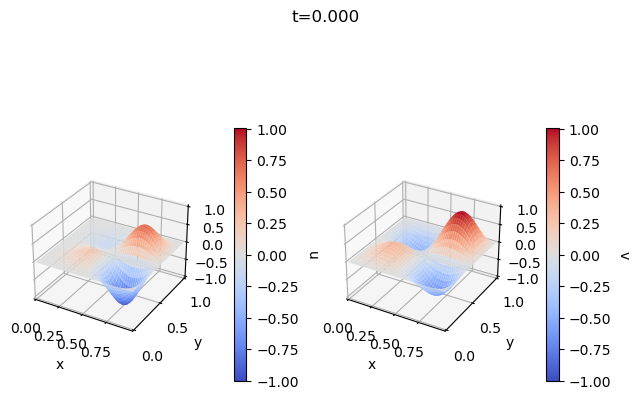

In [25]:
skip_frame = 10

fig = plt.figure()
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

sf1, sf2 = plot_2d(ax1, ax2, position, trajectory[0], to_periodic=False)
cbar1 = fig.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = fig.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")

fig.tight_layout()


def update(frame: int) -> None:
    ax1.clear()
    ax2.clear()
    frame *= skip_frame
    plot_2d(ax1, ax2, position, trajectory[frame], to_periodic=False)
    fig.suptitle(f"t={time[frame]:.3f}")
    fig.tight_layout()


anim = FuncAnimation(fig, update, frames=int(len(trajectory) / skip_frame), interval=50)
# anim.save(str(FIG_DIR / "burgers_example.gif"))
anim.save("temp.gif")

# 1D

In [ ]:
Lx, Ly = 1.0, 1.0  # x, y length of the domain

args = argument.get_args(
    [
        "--name", "IC_train",
        "--Nx", "100",
        "--Ny", "1",
        "--dx_delta", "0.1",
        "--nu", "0.01",
        "--num_samples", "1",
        "--seed", "0",
        "--const_graph",
        "--const_dt",
        "--const_param",
    ]
)

rng = np.random.default_rng(args.seed)
rng_ic = rng if args.seed_ic is None else np.random.default_rng(args.seed_ic)

# Grid setting
Nx, Ny = argument.get_NxNy(args.Nx, args.Ny, rng)
ndim = int(Nx > 1) + int(Ny > 1)  # 1 or 2

dx, dy = argument.get_dxdy((Lx, Ly), (Nx, Ny), args.dx_delta, tuple(args.dx_clip), rng)
position = dxdy2pos(dx, dy)  # [Ny+1, Nx+1, 2]

# dt setting
dts = argument.get_dt(
    args.max_time, args.steps, args.dt_delta, tuple(args.dt_clip), rng
)

# params(nu) setting
nu = argument.get_nu(ndim, args.nu, rng)


# Initial condition setting
get_initial_condition = argument.get_initial_condition(
    (Lx, Ly),
    ndim,
    args.num_cycles_ux,
    args.num_cycles_uy,
    args.num_cycles_vx,
    args.num_cycles_vy,
    rng_ic,
)
initial_field = get_initial_condition(position[:-1, :-2])   # [Ny, Nx, 2]

In [ ]:
# Solve burgers equation
fields_grid = solve_grid(  # [S+1, Nx*Ny, 2]
    args.solver, (dx, dy), nu, initial_field, dts
)

## Plot

In [ ]:
trajectory = np.stack([node2grid(traj, Nx) for traj in fields_grid], axis=0)
time = np.insert(np.cumsum(dts), 0, 0.0)
position_1d = position[0, :, :1]    # [Nx+1, 1]

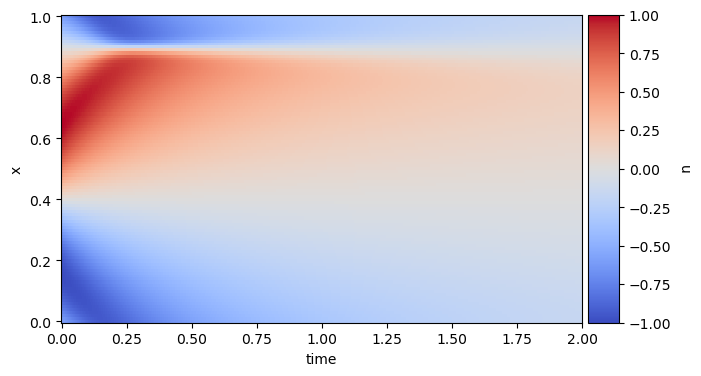

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

im = plot_1d_image(ax, time, position_1d, trajectory, rasterized=True)
cbar = fig.colorbar(im, ax=ax, location="right", pad=0.01, aspect=10)
cbar.ax.set_ylabel("u", rotation=-90, va="bottom")
ax.set_xlabel("time")
ax.set_ylabel("x")

fig.savefig(str(FIG_DIR / "burgers_example_1d.png"))
fig.show()